<a href="https://colab.research.google.com/github/JulianCarvajal/ProyectoIA/blob/main/05_modelo_con_preprocesamiento_de_nulos_por_mediana_y_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.1 MB/s eta 0:00:00


## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

 80% 24.0M/29.9M [00:00<00:00, 243MB/s]
100% 29.9M/29.9M [00:00<00:00, 263MB/s]


## unzip and inspect data

In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv', encoding = 'utf-8')
df.shape

(692500, 21)

## Funciones reutilizables

In [ ]:
from unidecode import unidecode

def clean_text(colum_name):
  df[colum_name] = (
      df[colum_name]
      .astype(str)                            # Asegura que todo sea texto
      .str.lower()                            # Convierte a minúsculas
      .str.strip()                            # Quita espacios al principio/final
      .apply(unidecode)                       # Elimina tildes
      .str.replace(r'\s+', ' ', regex=True)   # Sustituye múltiples espacios por uno solo
  )


In [ ]:
import pandas as pd
from rapidfuzz import fuzz, process
import re
from unidecode import unidecode

# --- 1. Función de Pre-procesamiento Robusto (Sin cambios, ya está en la función de limpieza) ---
def preprocesar_texto(texto):
    texto = str(texto).lower()
    texto = unidecode(texto)
    texto = re.sub(r'[^a-z0-9\s]', '', texto) # Esto maneja el '?' y otros especiales
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# --- 2. Función de Limpieza de Columna con Fuzzy Matching (MEJORADA CON DEBUG) ---
def limpiar_columna_fuzzy_debug(df, columna_a_limpiar, umbral=85):
    df_temp = df.copy()

    # Aplicar el pre-procesamiento a una nueva columna temporal
    columna_preprocesada = f"{columna_a_limpiar}_preprocesada"
    df_temp[columna_preprocesada] = df_temp[columna_a_limpiar].apply(preprocesar_texto)

    # Obtener los programas únicos de la columna pre-procesada
    programas_unicos_preproc = df_temp[columna_preprocesada].unique().tolist()

    mapeo_programas_preproc_a_canonico = {}
    programas_preproc_procesados = set()

    # Iterar sobre cada programa único pre-procesado
    for i, programa_actual_preproc in enumerate(programas_unicos_preproc):
        if programa_actual_preproc in programas_preproc_procesados:
            continue

        nombre_canonico_preproc = programa_actual_preproc
        mapeo_programas_preproc_a_canonico[programa_actual_preproc] = nombre_canonico_preproc
        programas_preproc_procesados.add(programa_actual_preproc)
        print(f"\n[{i+1}/{len(programas_unicos_preproc)}] Estableciendo canónico: '{nombre_canonico_preproc}'")

        # Busca coincidencias entre este canónico y los programas que aún no se han mapeado
        opciones_a_comparar = [p for p in programas_unicos_preproc if p not in programas_preproc_procesados]

        if not opciones_a_comparar:
            print(f"  No hay más opciones para comparar con '{nombre_canonico_preproc}'.")
            continue

        coincidencias = process.extract(
            query=programa_actual_preproc,
            choices=opciones_a_comparar,
            scorer=fuzz.token_set_ratio,
            limit=None
        )

        found_match_in_group = False
        for posible_variacion_preproc, puntuacion, _ in coincidencias:
            if puntuacion >= umbral:
                if posible_variacion_preproc not in programas_preproc_procesados:
                    mapeo_programas_preproc_a_canonico[posible_variacion_preproc] = nombre_canonico_preproc
                    programas_preproc_procesados.add(posible_variacion_preproc)
                    print(f"  -> Mapeando '{posible_variacion_preproc}' (score: {puntuacion}) a '{nombre_canonico_preproc}'")
                    found_match_in_group = True
            # DEBUG: Mostrar coincidencias cercanas pero que no cumplen el umbral
            elif puntuacion > umbral - 15: # Mostrar si la puntuación es ~15 puntos por debajo del umbral
                 print(f"  -> IGNORANDO '{posible_variacion_preproc}' (score: {puntuacion}) para '{nombre_canonico_preproc}' - Puntuación muy baja.")

        if not found_match_in_group and len(opciones_a_comparar) > 0:
            print(f"  No se encontraron coincidencias por encima del umbral={umbral} para '{nombre_canonico_preproc}' en las {len(opciones_a_comparar)} opciones restantes.")


    # --- Paso para obtener la forma ORIGINAL del nombre canónico ---
    # Crear un mapeo inverso de la forma preprocesada canónica a una de sus formas originales
    canonical_preproc_a_original_map = {}
    for original_val, preprocessed_val in df_temp[[columna_a_limpiar, columna_preprocesada]].drop_duplicates().values:
        if preprocessed_val in mapeo_programas_preproc_a_canonico:
            cleaned_preprocessed_val = mapeo_programas_preproc_a_canonico[preprocessed_val]
            if cleaned_preprocessed_val not in canonical_preproc_a_original_map:
                canonical_preproc_a_original_map[cleaned_preprocessed_val] = original_val
        else:
            # En casos muy raros donde un preprocesado no fue mapeado (debería ser handled por el 'else' del bucle)
            if preprocessed_val not in canonical_preproc_a_original_map:
                canonical_preproc_a_original_map[preprocessed_val] = original_val

    # Aplicar este mapeo para obtener la columna final limpia con nombres originales
    df_temp[f'{columna_a_limpiar}_limpio'] = df_temp[f'{columna_a_limpiar}_preprocesada'].map(mapeo_programas_preproc_a_canonico).map(canonical_preproc_a_original_map)

    # Eliminar las columnas temporales preprocesadas
    df_final = df_temp.drop(columns=[columna_preprocesada]) # Ya no necesitamos la preproc, ni la limpia_preproc

    # Construir el diccionario de mapeo final (original -> original_limpio) para el retorno
    final_mapeo_para_retornar = {}
    for original_val in df[columna_a_limpiar].unique():
        preprocessed_val = preprocesar_texto(original_val)
        if preprocessed_val in mapeo_programas_preproc_a_canonico:
            cleaned_preprocessed_val = mapeo_programas_preproc_a_canonico[preprocessed_val]
            final_mapeo_para_retornar[original_val] = canonical_preproc_a_original_map.get(cleaned_preprocessed_val, original_val)
        else:
            # Fallback en caso de que un valor original no se haya mapeado (raro)
            final_mapeo_para_retornar[original_val] = original_val

    num_unicos_final = len(df_final[f'{columna_a_limpiar}_limpio'].unique())
    # print("\n----------------------------------------------------------------------")
    # print(f"Número de programas únicos DESPUÉS de limpieza: {num_unicos_final}")
    # if num_unicos_final == len(programas_unicos_preproc):
    #     print("ADVERTENCIA: No se realizó ninguna agrupación. Considera bajar el umbral o revisar tus datos.")
    # print("----------------------------------------------------------------------")

    return df_final, final_mapeo_para_retornar

## Data Processing

### Codificación de variables categóricas

#### Rendimiento

In [ ]:
def clean_performance(df):
  maped_performance_values = {'bajo': 1, 'medio-bajo':2, 'medio-alto':3, 'alto':4}
  df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(maped_performance_values)
  return df['RENDIMIENTO_GLOBAL']

#### Familia con internet

In [ ]:
def clean_internet(df):
  maped_internet_values = {'Si': 1, 'No':0}
  df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].map(maped_internet_values)

#### Familia con internet (Columna repetida con "si" y "no" cómo respuesta)

In [ ]:
def clean_internet_1(df):
  del(df['FAMI_TIENEINTERNET.1'])

#### Valor matrícula

In [ ]:
def clean_matr(df):
  maped_tuition_values = {'No pagó matrícula': 0,
                          'Menos de 500 mil':1,
                          'Entre 500 mil y menos de 1 millón':2,
                          'Entre 1 millón y menos de 2.5 millones':3,
                          'Entre 2.5 millones y menos de 4 millones':4,
                          'Entre 4 millones y menos de 5.5 millones':5,
                          'Entre 5.5 millones y menos de 7 millones':6,
                          'Más de 7 millones':7}
  df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(maped_tuition_values)

#### Horas de trabajo semanales

In [ ]:
def clean_work_hours(df):
  maped_working_values = {'0': 0,
                          'Menos de 10 horas':1,
                          'Entre 11 y 20 horas':2,
                          'Entre 21 y 30 horas':3,
                          'Más de 30 horas':4}
  df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].map(maped_working_values)

#### Estrato

In [ ]:
def clean_stratum(df):
  maped_estrato_values = {'0': 0,
                          'Estrato 1':1,
                          'Estrato 2':2,
                          'Estrato 3':3,
                          'Estrato 4':4,
                          'Estrato 5':5,
                          'Estrato 6':6}
  df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].map(maped_estrato_values)

#### Educación padre

In [ ]:
def clean_p_education(df):
  maped_education_values = {'Ninguno': 0,
                          'Primaria incompleta':1,
                          'Primaria completa':2,
                          'Secundaria (Bachillerato) incompleta':3,
                          'Secundaria (Bachillerato) completa':4,
                          'Técnica o tecnológica incompleta':5,
                          'Técnica o tecnológica completa':6,
                          'Educación profesional incompleta':7,
                          'Educación profesional completa':8,
                          'Postgrado':9}
  df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].map(maped_education_values)

#### Educación madre

In [ ]:
def clean_m_education(df):
  maped_education_values = {'Ninguno': 0,
                          'Primaria incompleta':1,
                          'Primaria completa':2,
                          'Secundaria (Bachillerato) incompleta':3,
                          'Secundaria (Bachillerato) completa':4,
                          'Técnica o tecnológica incompleta':5,
                          'Técnica o tecnológica completa':6,
                          'Educación profesional incompleta':7,
                          'Educación profesional completa':8,
                          'Postgrado':9}
  df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].map(maped_education_values)

#### Tiene lavadora

In [ ]:
def clean_washing_machine(df):
  maped_washing_values = {'No': 0,
                          'Si': 1}
  df['FAMI_TIENELAVADORA'] = df['FAMI_TIENELAVADORA'].map(maped_washing_values)

#### Tiene automovil

In [ ]:
def clean_car(df):
  maped_car_values = {'No': 0,
                      'Si': 1}
  df['FAMI_TIENEAUTOMOVIL'] = df['FAMI_TIENEAUTOMOVIL'].map(maped_car_values)

#### Privado de la libertad

In [ ]:
def clean_priv_lib(df):
  maped_estu_priv_values = {'N': 0,
                      'S': 1}
  df['ESTU_PRIVADO_LIBERTAD'] = df['ESTU_PRIVADO_LIBERTAD'].map(maped_estu_priv_values)

#### Se paga su matrícula

In [ ]:
def clean_own_pay(df):
  maped_ownpay_values = {'No': 0,
                      'Si': 1}
  df['ESTU_PAGOMATRICULAPROPIO'] = df['ESTU_PAGOMATRICULAPROPIO'].map(maped_ownpay_values)

#### Tiene computador

In [ ]:
def clean_own_pc(df):
  maped_ownpc_values = {'No': 0,
                      'Si': 1}
  df['FAMI_TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].map(maped_ownpc_values)

### Codificación One-hot encoding para variables categóricas no ordinales

In [ ]:
def clean_dpto(df):
  df['ESTU_PRGM_DEPARTAMENTO'] = df['ESTU_PRGM_DEPARTAMENTO'].str.strip().str.upper()

  df_aux = pd.get_dummies(df,
                              columns=['ESTU_PRGM_DEPARTAMENTO'],
                              prefix='DEPTO',
                              prefix_sep='_',
                              dtype='uint8')
  return df_aux

In [ ]:
def clean_periodo(df):
  df_aux = pd.get_dummies(df,
                              columns=['PERIODO'],
                              prefix='PERIODO',
                              prefix_sep='_',
                              dtype='uint8')
  return df_aux

In [ ]:
import unicodedata

def clean_program(df):
  # Paso 1: Crear una función de limpieza para normalizar los nombres de los programas.
  def limpiar_texto(texto):
      if not isinstance(texto, str):
          return texto

      texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
      texto = texto.lower().strip().replace('-', ' ').replace('.', '').replace(',', '')
      return ' '.join(texto.split())

  # Paso 2: Aplicar la limpieza para crear una columna de trabajo temporal.
  df['ESTU_PRGM_ACADEMICO_LIMPIO'] = df['ESTU_PRGM_ACADEMICO'].apply(limpiar_texto)
  del(df['ESTU_PRGM_ACADEMICO'])
  print("aaaaaaaaa")
  # Paso 3: Agrupar por frecuencia (mantenemos los 30 programas mas frecuentes).
  N = 30
  top_n_programas = df['ESTU_PRGM_ACADEMICO_LIMPIO'].value_counts().nlargest(N).index

  # Creamos otra columna temporal con los programas agrupados.
  df['PRGM_AGRUPADO_TEMP'] = df['ESTU_PRGM_ACADEMICO_LIMPIO'].where(df['ESTU_PRGM_ACADEMICO_LIMPIO'].isin(top_n_programas), 'OTRO')

  # Paso 4: Aplicar One-Hot Encoding sobre la columna agrupada.
  df = pd.get_dummies(df, columns=['PRGM_AGRUPADO_TEMP'], prefix='PRGM', dtype=int)

  # Paso 5: Limpieza final. Eliminamos las columnas temporales que creamos.
  # Las columnas originales no se tocan.
  del(df['ESTU_PRGM_ACADEMICO_LIMPIO'])
  return df


## Tratamiento de datos nulos

In [ ]:
def clean_nulls(df):
  columnas_numericas = [
      'ESTU_VALORMATRICULAUNIVERSIDAD',
      'ESTU_HORASSEMANATRABAJA'
  ]

  columnas_categoricas = [
      'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
      'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PAGOMATRICULAPROPIO',
      'FAMI_TIENECOMPUTADOR', 'FAMI_EDUCACIONMADRE'
  ]

  # 1. Reemplazamos los valores nulos con la mediana
  for col in columnas_numericas:
      mediana = df[col].median()
      df[col] = df[col].fillna(mediana)

  # 2. Reemplazamos los valores nulos con la MODA
  for col in columnas_categoricas:
      moda = df[col].mode()[0]
      df[col] = df[col].fillna(moda)

## Get Data ready for training

In [ ]:
def clean_data(df):
  # clean_performance(df)
  clean_internet(df)
  clean_internet_1(df)
  clean_matr(df)
  clean_work_hours(df)
  clean_stratum(df)
  clean_p_education(df)
  clean_m_education(df)
  clean_washing_machine(df)
  clean_car(df)
  clean_priv_lib(df)
  clean_own_pay(df)
  clean_own_pc(df)
  df = clean_dpto(df)
  df = clean_periodo(df)
  df = clean_program(df)
  clean_nulls(df)
  return df

Importamos los datos de train y de test

In [ ]:
dtr = pd.read_csv('train.csv', encoding = 'utf-8')
dts = pd.read_csv('test.csv', encoding = 'utf-8')
lentr = len(dtr)
dtr.shape, dts.shape

((692500, 21), (296786, 20))

Juntamos train y test con el objetivo de realizar limpieza a ambos datasets de una forma mas comoda

In [ ]:
source_cols = [i for i in dtr.columns if i != 'RENDIMIENTO_GLOBAL']
all_data = pd.concat([dtr[source_cols], dts[source_cols]])
all_data.index = range(len(all_data))
all_data = clean_data(all_data)

xtr, ytr = all_data.iloc[:lentr].values, clean_performance(dtr).values
xts = all_data.iloc[lentr:].values

print(xtr.shape, ytr.shape, xts.shape)

aaaaaaaaa
(692500, 87) (692500,) (296786, 87)


Decidimos separar el dataframe de 'train' en una proporcion 70 - 30 con el objetivo de probar la calibracion del modelo con datos no vistos antes de realizar la prueba final dentro de kaggle para tener una aproximacion de que modelo con que pre-procesado funciona mejor

In [ ]:
from sklearn.model_selection import train_test_split

xtr, xval, ytr, yval = train_test_split(xtr, ytr, test_size=0.3)
xtr.shape, xval.shape, ytr.shape, yval.shape

((484750, 87), (207750, 87), (484750,), (207750,))

Utilizamos un 'arbol de decision' con una profundidad maxima 10 (tras realizar pruebas, fue la profundidad que mejor resultado nos dio tras entrenar el modelo y validarlo unicamente con el dataset 'train')

In [ ]:
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10)
dt.fit(xtr,ytr)

y_pred = dt.predict(xval)

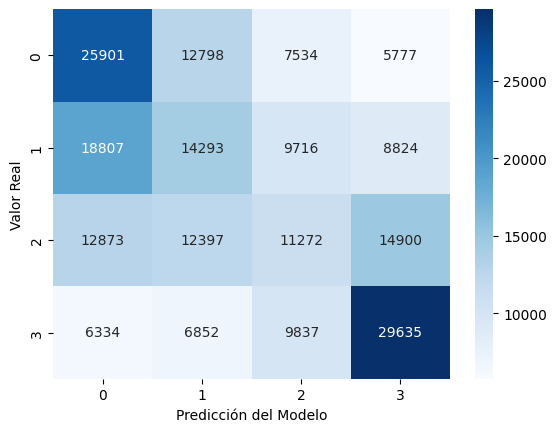

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar la matriz de confusión
cm = confusion_matrix(yval, y_pred)

# Visualizarla para que sea más fácil de entender
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(yval, y_pred)
print(f"Precisión (Accuracy): {accuracy:.4f}")

Precisión (Accuracy): 0.3904
